In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [68]:
data = pd.read_csv("datos/monthly-car-sales.csv")

In [69]:
data.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [70]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)


In [71]:
print(data.head())
print(data.index)


            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587
DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '1968-03-01', '1968-04-01', '1968-05-01', '1968-06-01',
               '1968-07-01', '1968-08-01', '1968-09-01', '1968-10-01',
               '1968-11-01', '1968-12-01'],
              dtype='datetime64[ns]', name='Month', length=108, freq=None)


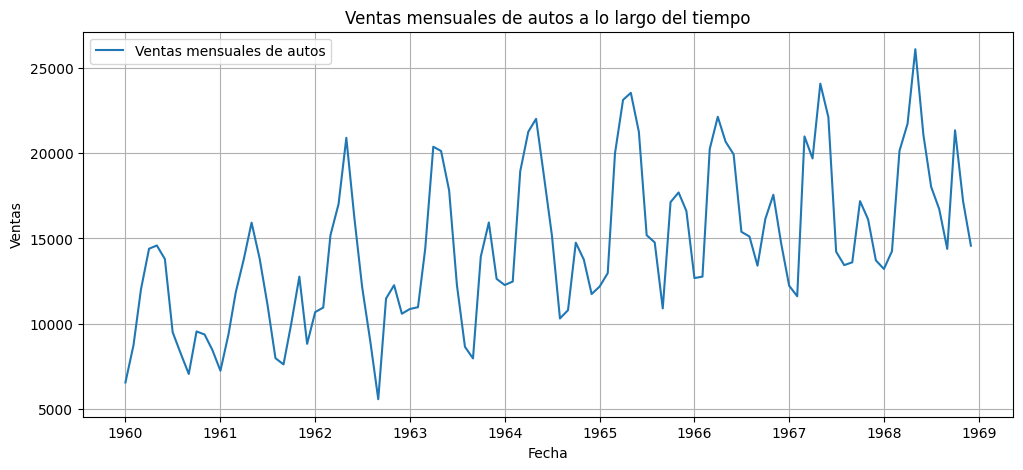

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(data['Sales'], label='Ventas mensuales de autos')
plt.title('Ventas mensuales de autos a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

## Análisis Exploratorio

              Sales
count    108.000000
mean   14595.111111
std     4525.213913
min     5568.000000
25%    11391.250000
50%    14076.000000
75%    17595.750000
max    26099.000000
Fechas: 1960-01-01 00:00:00 → 1968-12-01 00:00:00
Nulos: Sales    0
dtype: int64


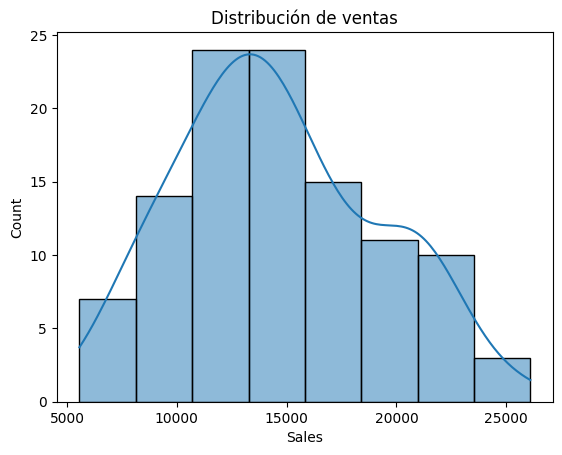

In [73]:
print(data.describe())
print("Fechas:", data.index.min(), "→", data.index.max())
print("Nulos:", data.isnull().sum())

# Gráfico de distribución
sns.histplot(data['Sales'], kde=True)
plt.title("Distribución de ventas")
plt.show()


> - Hay 240 días registrados, van desde el inicio del año **1920**, hasta finales del **1939**
> - Predomina la temperatura entre 39°F y 43°F

## Promedios Móviles

In [74]:
data['MA_3'] = data['Sales'].rolling(window=3).mean()
data['MA_12'] = data['Sales'].rolling(window=12).mean()

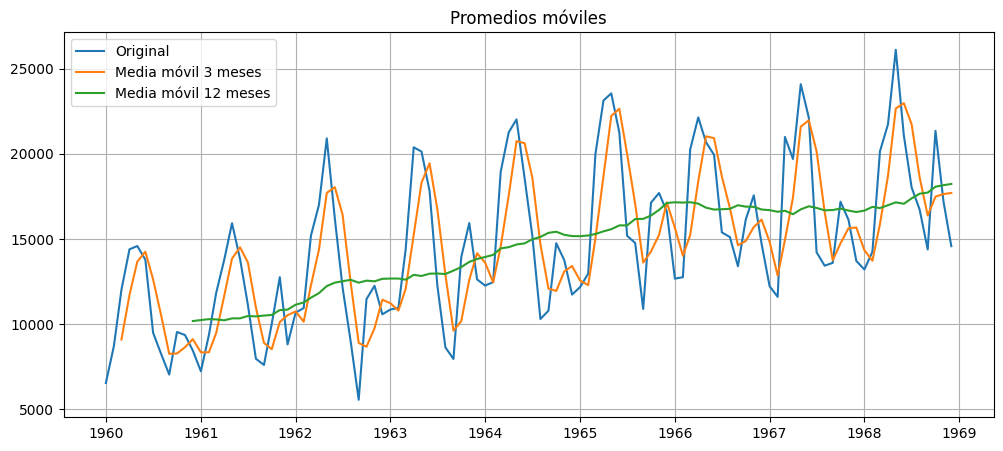

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(data['Sales'], label='Original')
plt.plot(data['MA_3'], label='Media móvil 3 meses')
plt.plot(data['MA_12'], label='Media móvil 12 meses')
plt.title('Promedios móviles')
plt.legend()
plt.grid(True)
plt.show()


El promedio móvil de 12 meses se aplicó a la serie de ventas de vehículos para disminuir la variabilidad mensual y resaltar patrones generales. Al reducir fluctuaciones menores, la curva suavizada muestra una tendencia central clara.

Comparando con la serie original, los datos mensuales exhiben picos y caídas marcadas, especialmente en agosto-septiembre y noviembre-diciembre, mientras que la media móvil de 12 meses ofrece una trayectoria más constante. Esto destaca incrementos hacia noviembre y descensos en diciembre, con una subida general a lo largo de los años. La media móvil de 3 meses capta mejor los picos originales. Este análisis ayuda a identificar patrones estacionales sin necesidad de datos externos.

## Aislamiento Exponencial Simple

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


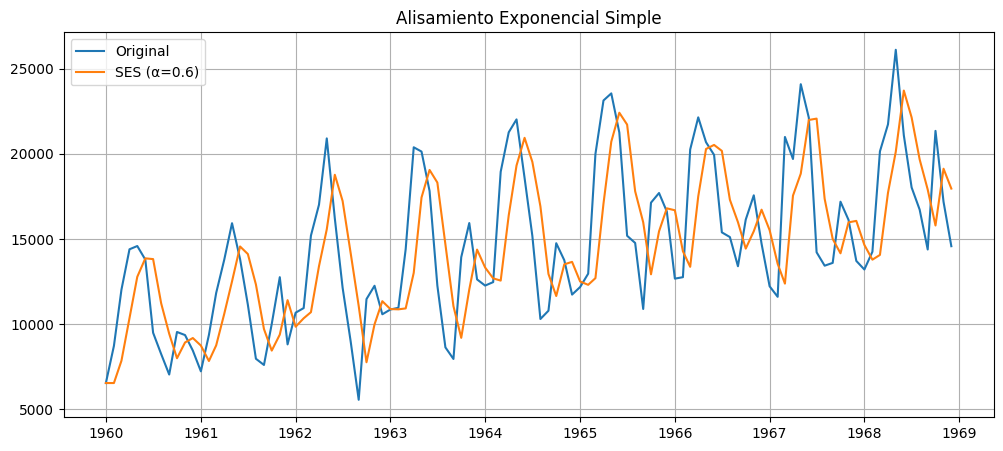

In [85]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_ses = SimpleExpSmoothing(data['Sales']).fit(smoothing_level=0.6, optimized=False)
data['SES'] = model_ses.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Sales'], label='Original')
plt.plot(data['SES'], label='SES (α=0.6)')
plt.title('Alisamiento Exponencial Simple')
plt.legend()
plt.grid(True)
plt.show()


Este modelo está bastante cercano respecto a predecir los picos en las épocas correctas, sin embargo no es del todo exácto para predecir los valores de los extremos.

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


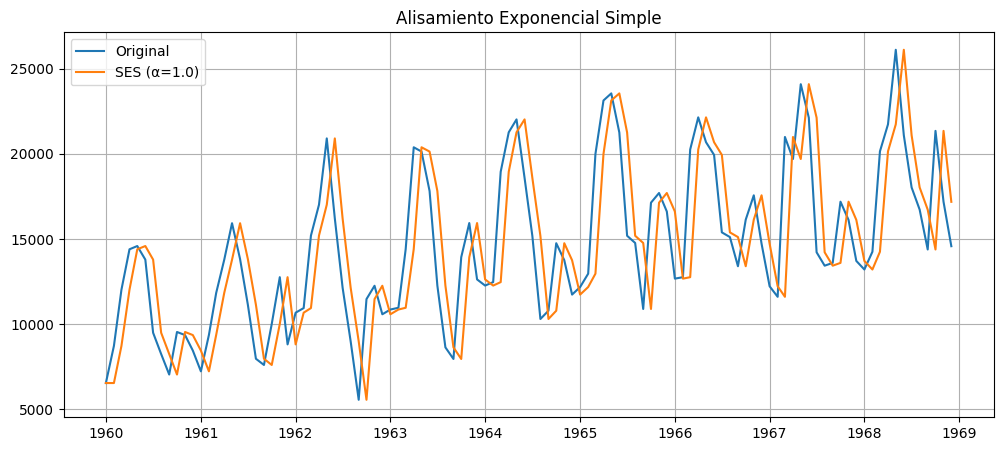

In [87]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_ses = SimpleExpSmoothing(data['Sales']).fit(smoothing_level=1.0, optimized=False)
data['SES-mejorado'] = model_ses.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Sales'], label='Original')
plt.plot(data['SES-mejorado'], label='SES (α=1.0)')
plt.title('Alisamiento Exponencial Simple')
plt.legend()
plt.grid(True)
plt.show()


El modelo, ahora con `α = 1.0`, muestra una mejora notable en comparación con la versión anterior, evidenciando un ajuste visual mucho más cercano a la serie original. No obstante, este comportamiento se logra a costa de sacrificar el propósito principal del alisamiento exponencial, ya que el modelo se comporta casi como una réplica desplazada de los valores observados. Este tipo de configuración podría ser útil en contextos donde no se busca modelar tendencia ni estacionalidad, sino simplemente reaccionar de manera inmediata a los cambios recientes en los datos.

## Holt-Winters

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


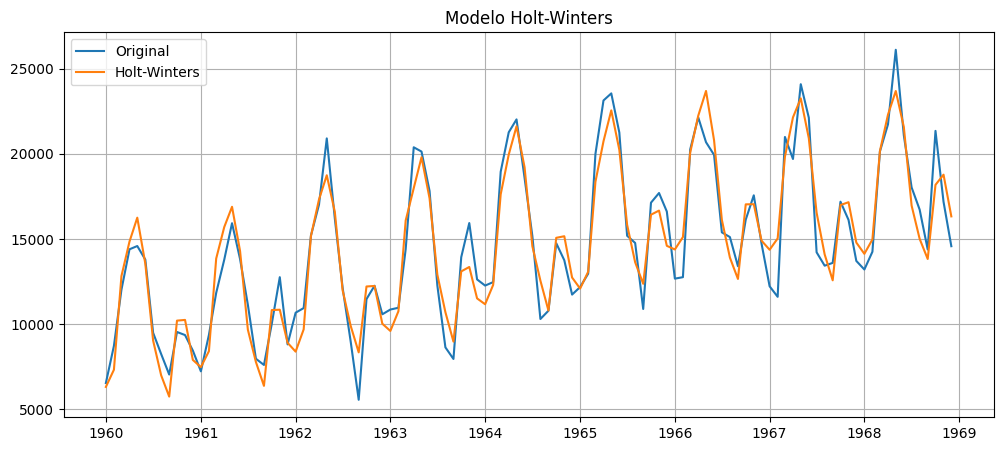

In [78]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(data['Sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
data['HW'] = model_hw.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Sales'], label='Original')
plt.plot(data['HW'], label='Holt-Winters')
plt.title('Modelo Holt-Winters')
plt.legend()
plt.grid(True)
plt.show()


## SARIMA

Primero, para hallar los mejores parámetros, se realizó el siguiente análisis:

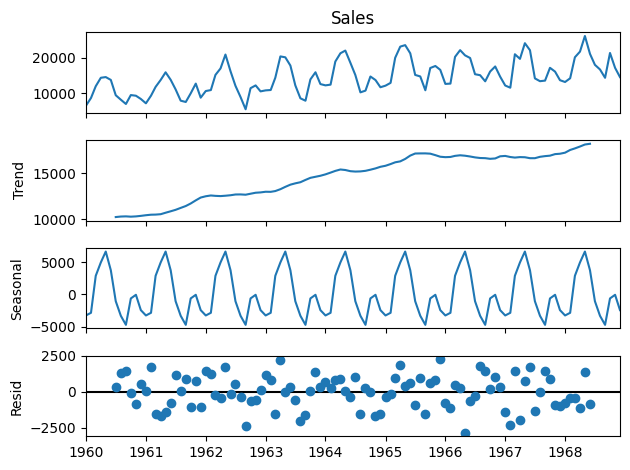

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Sales'], model='additive', period=12)
result.plot()
plt.show()

Se logran observar fluctuaciones **estacionales** y una tendencia general **ascendente**, lo que sugiere que se necesitará un término de diferenciación `d` para hacer la serie estacionaria y un componente estacional `D` para manejar la estacionalidad.

Respecto a la gráfica **trend**, esta nos confirma que una diferenciación ordinaria (`d = 1`) podría ser necesaria para estabilizar la media.

Ahora para estimar los valores `p` y `q`, se crearon las siguientes gráficas:

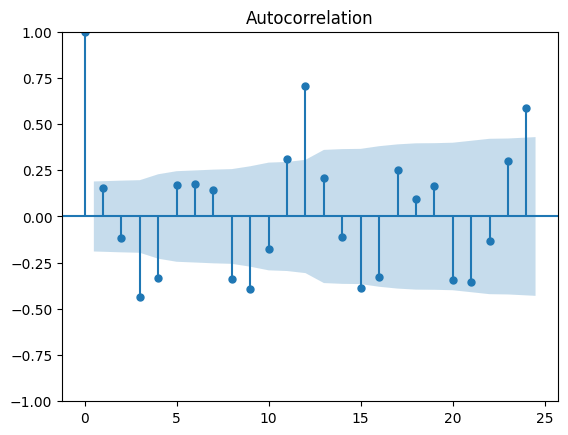

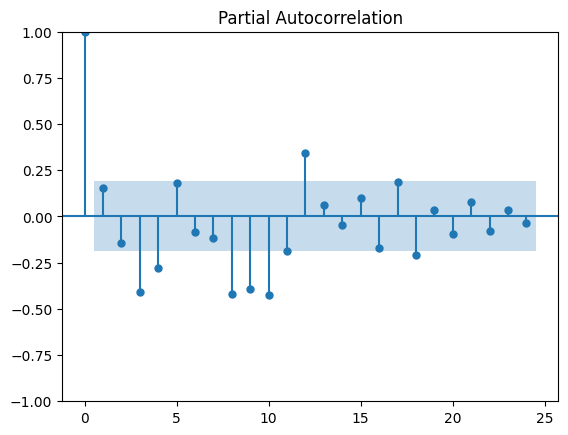

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Sales'].diff().dropna(), lags=24)
plot_pacf(data['Sales'].diff().dropna(), lags=24)
plt.show()

Para la gráfica **ACF**, los picos más visibles están en el **1**, con un decaimiento lento que sugiere **estacionalidad** y la necesidad de una diferenciación de **`d = 1`** para estabilizar la serie. Esto también indica que un componente MA (`q`) podría ser necesario, y el patrón inicial sugiere un posible período estacional (`s`) que podrías explorar según la frecuencia de tus datos (por ejemplo, 12 si es mensual).

Por otro lado, para la gráfica **PACF**, se observa un pico significativo en el lag 1, con un decaimiento rápido thereafter, indicando un componente AR de orden `p = 1`.

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


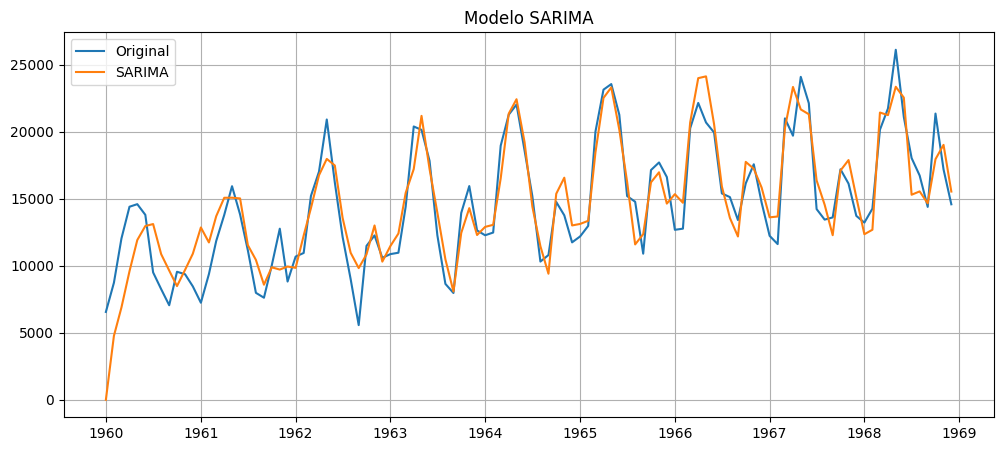

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 1
d = 1
q = 1

P = 1
D = 1
Q = 1
s = 12

model_sarima = SARIMAX(data['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
data['SARIMA'] = model_sarima.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Sales'], label='Original')
plt.plot(data['SARIMA'], label='SARIMA')
plt.title('Modelo SARIMA')
plt.legend()
plt.grid(True)
plt.show()


## Prophet

03:48:12 - cmdstanpy - INFO - Chain [1] start processing
03:48:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


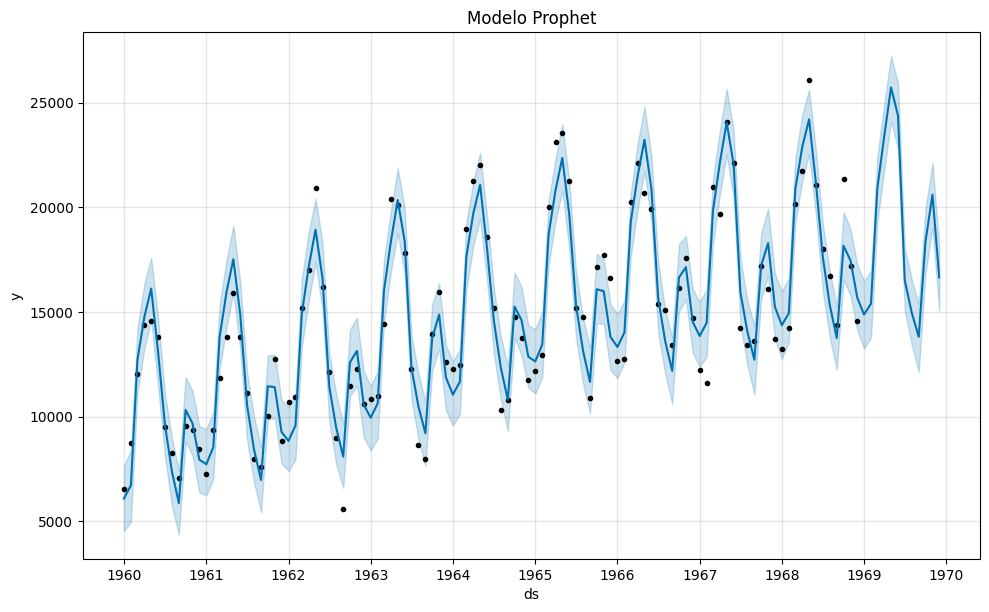

In [82]:
from prophet import Prophet

df_prophet = data.reset_index().rename(columns={'Month': 'ds', 'Sales': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast = model_prophet.predict(future)

# Visualización
model_prophet.plot(forecast)
plt.title('Modelo Prophet')
plt.show()

# Integrar predicciones al DataFrame original
df_prophet['Prophet'] = model_prophet.predict(df_prophet)[['yhat']]
data['Prophet'] = df_prophet.set_index('ds')['Prophet']


## Comparación y Evaluación de Modelos

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluar_modelo(real, predicho):
    mae = mean_absolute_error(real, predicho)
    rmse = np.sqrt(mean_squared_error(real, predicho))
    return mae, rmse

resultados = {
    'SES': evaluar_modelo(data['Sales'], data['SES']),
    'SES-mejorado': evaluar_modelo(data['Sales'], data['SES-mejorado']),
    'Holt-Winters': evaluar_modelo(data['Sales'], data['HW']),
    'SARIMA': evaluar_modelo(data['Sales'], data['SARIMA']),
    'Prophet': evaluar_modelo(data['Sales'], data['Prophet'])
}

resultados_df = pd.DataFrame(resultados, index=['MAE', 'RMSE']).T
print(resultados_df.sort_values('RMSE'))



                      MAE         RMSE
Prophet       1025.959595  1248.591714
Holt-Winters  1083.298459  1335.874205
SARIMA        1587.980729  2005.790394
SES-mejorado  2605.287037  3298.227154
SES           3022.918218  3633.474023


Tenemos valores bastantes grandes debido a las cantidades de ventas de vehículos, por lo que utilizaremos el error porcentual medio absoluto para facilitar el análisis de los resultados:

In [90]:
def calcular_mape(real, predicho):
    return np.mean(np.abs((real - predicho) / real)) * 100

mape_resultados = {
    'SES': calcular_mape(data['Sales'], data['SES']),
    'SES-mejorado': calcular_mape(data['Sales'], data['SES-mejorado']),
    'Holt-Winters': calcular_mape(data['Sales'], data['HW']),
    'SARIMA': calcular_mape(data['Sales'], data['SARIMA']),
    'Prophet': calcular_mape(data['Sales'], data['Prophet'])
}

for modelo, mape in mape_resultados.items():
    print(f"{modelo}: MAPE = {mape:.2f}%")


SES: MAPE = 21.93%
SES-mejorado: MAPE = 18.49%
Holt-Winters: MAPE = 8.15%
SARIMA: MAPE = 13.12%
Prophet: MAPE = 7.68%


Al analizar el **error porcentual medio absoluto (MAPE)**, se observa que el modelo **Prophet** demuestra ser el más preciso, con un **MAPE** de `7.68%`, lo que indica que, en promedio, sus predicciones difieren menos del **8%** respecto a los valores reales. Le sigue muy de cerca el modelo **Holt-Winters**, con un **MAPE** de `8.15%`, lo cual también representa una excelente capacidad predictiva. Por su parte, **SARIMA** alcanzó un MAPE de `13.12%`, clasificándose como una predicción buena pero menos precisa en comparación con **Prophet** y **Holt-Winters**. Finalmente, en cuanto al **alisamiento exponencial simple (SES)**, el modelo original con `α = 0.6` obtuvo un MAPE de `21.93%`, indicando un ajuste limitado. No obstante, al ajustar el parámetro a `α = 1.0`, el SES mejoró su rendimiento a un MAPE de `18.49%`, reduciendo el error en comparación con su versión inicial. Aun así, ambos modelos SES se mantienen por debajo del rendimiento observado en los modelos que sí consideran estacionalidad y tendencia.